# 内容提要
- 原理与`sklearn`实现
  - 类间隔优化及其对偶问题
  - 间隔的软化
  - 在`sklearn`中调用支持向量机算法
- 核方法的引入
  - 常见的非线性核
- 超参数优化
  - 回顾: 标准流程
  - 用`sklearn.model_selection`内置工具管理超参数优化

In [10]:
%pip install -U scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simpleNote: you may need to restart the kernel to use updated packages.



# 原理与`sklearn`实现

$\quad$我们考虑一个(参数化的、非概率的)二元分类器

$$
\tilde{y} = \mathrm{sgn}(f(\mathbf{x};\mathbf{w})) \equiv \mathrm{sgn}(\mathbf{w}^\mathrm{T}\mathbf{x} + w_0),
$$

用于预测类别标签$\tilde{t} \in \{-1, 1\}$. 其中, 超平面$0 = f(\mathbf{x};\mathbf{w})$显然成为了决策边界.

$\quad$我们先在本节假定(assume)训练数据$\mathcal{D} = \{(\mathbf{x}^{(n)}, \tilde{t}^{(n)})\}_{n=1}^N$是**线性可分的**(linearly separable), 并试图在(无穷多个)成功分割了训练数据的决策平面中选择**稳健性**(robustness)最强的那个. 为此, **支持向量机**(support vector machine, SVM)算法将选择这样的超平面: *使得给定类别的样本点到该平面的最小距离仍然不小*, 也就是实现**最短距离的最大化**.

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/bc01554bbe7d4c05a1fae15a7bfdd714/yIkQ32rGFqnUz6gNkZV2ww.png)

在上图中, 对给定的样本点$\mathbf{x}$, 若以$r$代指有向距离, 则我们将单位法向量$\frac{\mathbf{w}}{\|\mathbf{w}\|}$倍乘$r$并从$\mathbf{x}$中扣除, 将得到$\mathbf{x}$在超平面$0=f$上的正交投影

$$
\mathbf{x}_\perp = \mathbf{x} - r\frac{\mathbf{w}}{\|\mathbf{w}\|},
$$

进而
$$\begin{aligned}
0
&= f(\mathbf{x}_\perp)\\
&= \mathbf{w}^\mathrm{T}\left(\mathbf{x} - r\frac{\mathbf{w}}{\|\mathbf{w}\|}\right) + w_0\\
&= f(\mathbf{x}) - r\|\mathbf{w}\|,
\end{aligned}$$

于是, 解得

$$
r = \frac{f(\mathbf{x})}{\|\mathbf{w}\|}.
$$

$\quad$不难验证, 对于线性可分的数据集$\mathcal{D}$, $r$总是与类别标签$\tilde{t}$同号. 于是, 对样本$n$, 待考察的优化目标(类间隔)$|r|$可写为

$$
\frac{\tilde{t}^{(n)}f(\mathbf{x}^{(n)})}{\|\mathbf{w}\|} = \frac{\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0)}{\|\mathbf{w}\|}.
$$

## 类间隔优化及其对偶问题

$\quad$我们试图寻找最优参数$(\mathbf{w}^*, w_0^*)$, 使之最大化$\mathcal{D}$上的最小类间隔. 于是,

$$
(\mathbf{w}^*, w_0^*) = \arg{\max_{(\mathbf{w}, w_0)}{\frac{1}{\|\mathbf{w}\|}\min_{n=1}^N{\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0)}}}.
$$

但注意$\mathbf{w}, w_0$的倍乘不影响分类结果, 于是, 不妨采用**规范表示**(canonical representation), 取$1=\min_{n=1}^N{\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0)}$, 上式化为**约束优化**(constrained optimization)问题

$$
(\mathbf{w}^*, w_0^*) = \arg{\max_{(\mathbf{w}, w_0)}{\frac{1}{\|\mathbf{w}\|}}},\,\,\mathrm{s.t.}\,\,\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0) \ge 1, n = 1, \dots, N.
$$

- **原问题**(primal problem): 上式等价地写为凸优化问题
  $$
  (\mathbf{w}^*, w_0^*) = \arg{\min_{(\mathbf{w}, w_0)}{\frac{1}{2}\|\mathbf{w}\|^2}},\,\,\mathrm{s.t.}\,\,\tilde{t}^{(n)} (\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0) \ge 1, n = 1, \dots, N,
  $$
  这是一个**二次规划**(quadratic programming, QP)问题, 存在标准化的算法用于求解.
- **对偶问题**(dual problem): 引入(非负的)Lagrange乘子$\boldsymbol{\lambda} \in \mathbb{R}_+^N$, 并等价地将原问题写为
  $$\begin{aligned}
  (\mathbf{w}^*, w_0^*, \boldsymbol{\lambda}^*) &= \arg{\min_{(\mathbf{w}, w_0)}{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\mathcal{L}}}},\\
  \mathcal{L} &= \frac{1}{2}\|\mathbf{w}\|^2 - \sum_{n=1}^N{\lambda_n\left(\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0) - 1\right)},
  \end{aligned}$$
  此时, 可以证明, 在[Karush-Kuhn-Tucker(KKT)条件](https://en.wikipedia.org/wiki/Karush%E2%80%93Kuhn%E2%80%93Tucker_conditions)下, 原问题的最优解也将是下述**对偶问题**(变换了“最小”与“最大”的求解顺序)的最优解:
  $$
  (\mathbf{w}^*, w_0^*, \boldsymbol{\lambda}^*) = \arg{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\min_{(\mathbf{w}, w_0)}{\mathcal{L}}}}.
  $$
  - 内层的优化问题可以解析地求解:
    $$\begin{aligned}
    \mathbf{0} &= \nabla_\mathbf{w}\mathcal{L} = \mathbf{w} - \sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}\mathbf{x}^{(n)}},\\
    0 &= \frac{\partial}{\partial w_0}\mathcal{L} = -\sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}},
    \end{aligned}$$
    截距项$w_0^*$则由决策边界$1 = \mathbf{w}^\mathrm{T}\mathbf{x}^{(l)} + w_0$求解得到, $l$代指的样本为规范表示中的“边界”.
  - 将这组解代入外层优化问题:
    $$\begin{aligned}
    \boldsymbol{\lambda}^* &= \arg{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\left\{
    \frac{1}{2}\left\|\sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}\mathbf{x}^{(n)}}\right\|^2 - \sum_{n=1}^N{\lambda_n\left(
    \tilde{t}^{(n)}\left(\left(\sum_{m=1}^N{\lambda_m\tilde{t}^{(m)}\mathbf{x}^{(m)}}\right)^\mathrm{T}\mathbf{x}^{(n)} + w_0
    \right) - 1\right)}\right\}}}\\
    &= \arg{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\left\{
    \sum_{n=1}^N{\lambda_n} - \frac{1}{2}\sum_{m=1}^N{\sum_{n=1}^N{
    \lambda_m\lambda_n\tilde{t}^{(m)}\tilde{t}^{(n)}\left<\mathbf{x}^{(m)}, \mathbf{x}^{(n)}\right>
    }}\right\}}},
    \end{aligned}$$
    式中, $\left<\mathbf{x}, \mathbf{y}\right> \equiv \mathbf{x}^\mathrm{T}\mathbf{y}$定义了**内积**(inner product)运算, 本质上是某种“相似性”的度量. 支持向量机作为**核方法**(kernel method)的一种, 核心原理是试图基于样本的相似性来学习类别归属、做出分类推断.
  - 可以用标准化的QP或更高效的[**序列最小优化**(sequential minimal optimization, SMO)](https://en.wikipedia.org/wiki/Sequential_minimal_optimization)算法求解. 同时, 以内积的形式描述特征$\mathbf{x}$之间的关系, 这对后续引入核方法是颇为有益的.

## 间隔的软化

$\quad$面对线性不可分的数据, 我们适度允许分类误差, 以缓解过拟合现象、提高模型(在个别离群点上)的稳健性. 此时, 引入(非负)松弛变量$\{\xi_n\}_{n=1}^N \in \mathbb{R}_+^N$, 并将约束条件放宽为

$$
\tilde{t}^{(n)}(\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0) \ge 1 - \xi_n, n = 1, \dots, N.
$$

此时, 若将$\{\xi_n\}$看作一组独立变量, 并引入软度超参数$C$, 则原问题与对偶问题将重新写为:

- 原问题:
  $$
  (\mathbf{w}^*, w_0^*) = \arg{\min_{(\mathbf{w}, w_0)}{\left\{\frac{1}{2}\|\mathbf{w}\|^2 + C\sum_{n=1}^N{\xi_n}\right\}}},\,\,\mathrm{s.t.}\,\,\xi_n \ge 0, \tilde{t}^{(n)} (\mathbf{w}^\mathrm{T}\mathbf{x}^{(n)} + w_0) \ge 1 - \xi_n, n = 1, \dots, N;
  $$
- 对偶问题:
  $$
  \boldsymbol{\lambda}^* = \arg{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\left\{
    \sum_{n=1}^N{\lambda_n} - \frac{1}{2}\sum_{m=1}^N{\sum_{n=1}^N{
    \lambda_m\lambda_n\tilde{t}^{(m)}\tilde{t}^{(n)}\left<\mathbf{x}^{(m)}, \mathbf{x}^{(n)}\right>
    }}\right\}}},\,\,\mathrm{s.t.}\,\, 0 \le \lambda_n \le C (n = 1, \dots, N), 0 = \sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}}.
  $$
- $C$值越小, 模型的间隔越“软”、对个别点的错分(misclassification)越宽容, 欠拟合的倾向性也就越强. $C=\infty$对应于前述的硬间隔(hard margin)问题.

## 在`sklearn`中调用支持向量机算法

$\quad$支持向量机分类器封装于[`sklearn.svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn-svm-svc), 创建模型后, 仍然是以[`fit()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit)方法进行模型训练、[`predict()`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict)方法进行推断(预测).
- **训练**阶段, 模型将数值地求解原问题或对偶问题(不同的算法模块有不同的具体实现), 寻找最优参数$\boldsymbol{\lambda}^*$.
- **预测**阶段, 模型对给定样本计算决策函数
  $$\begin{aligned}
  f(\mathbf{x}; \mathbf{w}) &= \mathbf{w}^\mathrm{T}(\mathbf{x} - \mathbf{x}^{(l)}) + 1\\
  &= \left(\sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}\mathbf{x}^{(n)}}\right)^\mathrm{T} (\mathbf{x} - \mathbf{x}^{(l)}) + 1,
  \end{aligned}$$
  并以$\mathrm{sgn}(f(\mathbf{x};\mathbf{w}))$值给出分类决策.
  - 可以证明, SVM总满足**KKT条件**. 此时, 对每个样本$n$, Lagrange参数和间隔值二者必有一个为零, 即:
    $$
    0 = \boldsymbol{\lambda} \odot \left(1 - \tilde{t}^{(n)}\tilde{y}^{(n)}\right).
    $$
    决策阶段真正重要的是那些$\lambda \ne 0$的样本, 它们称为**支持向量**(support vector), 是“最危险的”样本, 间隔取最小值.

$\quad$我们导入一组二维的[人造数据集](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#plot-classification-boundaries-with-different-svm-kernels)用于演示.

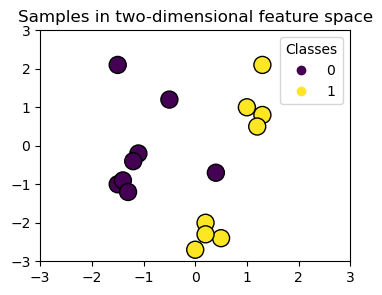

In [2]:
import matplotlib.pyplot as plt
import numpy as np

X = np.array([
        [0.4, -0.7],
        [-1.5, -1.0],
        [-1.4, -0.9],
        [-1.3, -1.2],
        [-1.1, -0.2],
        [-1.2, -0.4],
        [-0.5, 1.2],
        [-1.5, 2.1],
        [1.0, 1.0],
        [1.3, 0.8],
        [1.2, 0.5],
        [0.2, -2.0],
        [0.5, -2.4],
        [0.2, -2.3],
        [0.0, -2.7],
        [1.3, 2.1],
])

y = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

# Plotting settings
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = -3, 3, -3, 3
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plot samples by color and add legend
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Samples in two-dimensional feature space")
plt.show()

$\quad$以下是一个辅助函数, 利用[`sklearn.inspection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.inspection)模块的可视化工具[`DecisionBoundaryDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html#sklearn-inspection-decisionboundarydisplay)帮助我们可视化模型的**决策边界**(decision boundary). 我们先使用最简单的线性SVM分类器, 参数设置为`kernel="linear"`.

In [3]:
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay

def plot_training_data_with_decision_boundary(kernel):
    # Train the SVC
    clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Settings for plotting
    _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=250,
        facecolors="none",
        edgecolors="k",
    )
    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=150, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f"Decision boundaries of {kernel} kernel in SVC")

    plt.show()

$\quad$图中,
- 用实线示出决策边界, 虚线示出间隔值.
- 用空圈标明轮廓的样本是支持向量.

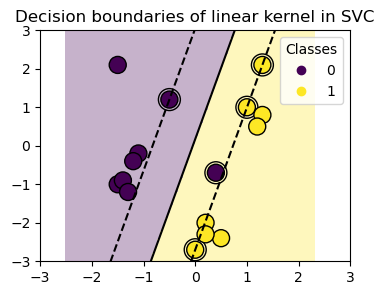

In [4]:
plot_training_data_with_decision_boundary("linear")

# 核方法的引入

$\quad$为了提高模型的表示能力(或者至少可以处理线性不可分的数据), 常对特征$\mathbf{x} \in \mathcal{X}$作某种非线性变换$$\phi: \mathcal{X} \to \mathcal{M},\mathbf{x}\mapsto\phi(\mathbf{x}),$$使训练样本在空间$\mathbf{M}$中具有更好的分布结构. 但比起研究$\phi$的形式本身, 一个计算效率更高的做法是直接研究“内积”:$$K_\phi: \mathcal{X}\times\mathcal{X}\to\mathbb{R}, K_\phi(\mathbf{x}, \mathbf{x}') = \left<\phi(\mathbf{x}), \phi(\mathbf{x}')\right>_\mathcal{M}.$$

$\quad$根据[Schölkopf-Herbrich-Smola表示定理](https://en.wikipedia.org/wiki/Representer_theorem), 只需要核函数$K_\phi$是**正定的**(positive-definite), 则经过训练后的决策平面$f(\mathbf{x})$总可以表示为有限项核函数的线性组合. 以下将介绍的几种常见核函数都是正定的. 核函数在设计上具有非常强的灵活性, 并且允许对特定数据引入特定领域的专业知识.

$\quad$定义**Gram矩阵**$$\mathbf{K}_\phi := \left(\left<\phi(\mathbf{x}^{(i)}), \phi(\mathbf{x}^{(j)})\right>_\mathcal{M}\right)_{1 \le i,j \le N},$$则引入了核方法的SVM(kernel-SVM)将求解下述的对偶问题:
$$
\boldsymbol{\lambda}^* = \arg{\max_{\boldsymbol{\lambda} \ge \mathbf{0}}{\left\{
    \sum_{n=1}^N{\lambda_n} - \frac{1}{2}\sum_{m=1}^N{\sum_{n=1}^N{
    \lambda_m\lambda_n\tilde{t}^{(m)}\tilde{t}^{(n)}(\mathbf{K}_\phi)_{m,n}
    }}\right\}}},\,\,\mathrm{s.t.}\,\, 0 \le \lambda_n \le C (n = 1, \dots, N), 0 = \sum_{n=1}^N{\lambda_n\tilde{t}^{(n)}}.
$$

## 常见的非线性核

- 多项式核函数`kernel="poly"`
  $$
  K(\mathbf{x}, \mathbf{x}') = (\gamma\mathbf{x}^\mathrm{T}\mathbf{x}' + r)^d.
  $$
  超参数包括:
  - `gamma`, 对应内积前的系数$\gamma$, 反映**对单个训练样本的敏感程度**. 它的默认取值为
    $$
    \gamma_0 = \frac{1}{N\sigma^2(\mathbf{X})},
    $$
    其中, $N$为训练样本数, $\sigma^2(\mathbf{X})$为数据方差.
  - `coef0`, 对应截距项$r$, 默认值为0;
  - `degree`, 对应多项式的度数$d$, 调节**模型的复杂程度**, 默认值为3.
- 决策边界与决策间隔会随着训练数据的分布而相应适当“弯曲”.

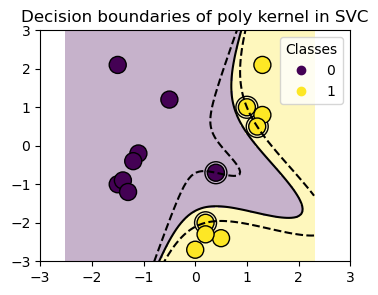

In [5]:
plot_training_data_with_decision_boundary("poly")

- Sigmoid核函数`kernel="sigmoid"`
  $$
  K(\mathbf{x}, \mathbf{x}') = \tanh{(\gamma\mathbf{x}^\mathrm{T}\mathbf{x}' + r)},
  $$
  - 超参数包括`gamma`和`coef0`, 分别代指$\gamma$与$r$.
- 实践中往往不推荐, 因为决策边界通常过于复杂且难以泛化(除非数据有着特殊的分布结构).

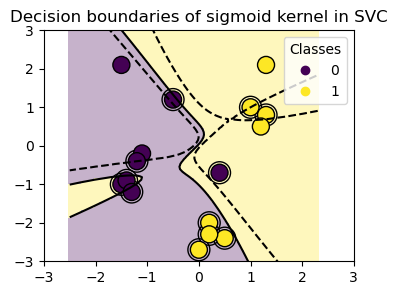

In [6]:
plot_training_data_with_decision_boundary("sigmoid")

- Gaussian核函数`kernel="rbf"`
  $$
  K(\mathbf{x}, \mathbf{x}') = \exp{\left(-\gamma\|\mathbf{x} - \mathbf{x}'\|^2\right)},
  $$
  - 超参数为`gamma`.
- 对应的非线性表示$\phi$有无穷维, 以Euclidean距离度量样本相似性, 因此决策边界也重在聚集距离相近的若干样本点. **它是`SVC`算法默认的核函数**.

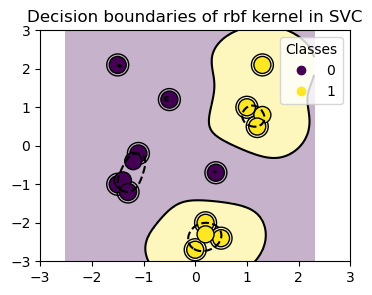

In [7]:
plot_training_data_with_decision_boundary("rbf")

# 超参数优化

![alt image.png](https://bohrium.oss-cn-zhangjiakou.aliyuncs.com/article/17993/a7014363f4954f5c8efc6b934e595800/85yhZBaNYLyWKp_0i-m68Q.png)

用伪代码表示如下.
```
metrics = []
for config in search_space:
    metrics.append(cross_validation(train_val_dataset, config))
best_config = argmax(metrics)
final_model = train(train_val_dataset, best_config)
```

## 用`sklearn.model_selection`内置工具管理超参数优化

$\quad$在[`sklearn.model_selection`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)模块中, 封装了用于超参数优化的[若干方法](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers), 可以一次性实现超参数的搜索空间采样与交叉验证. 每个优化方法都仍然是一个`sklearn`模型对象, 以`fit()`方法完成交叉验证. 在创建对象时, 传入的控制参数包括:
- `estimator`: 用于超参数优化的模型;
- `param_grid`: 超参数的**搜索空间**(search space), 定义成一个字典;
- `scoring`: 评估指标函数, 可以是[特定字符串](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)或一个(返回标量值的)函数, 或多个字符串/函数; 默认为`None`, 采取“默认”指标(例如分类问题是accuracy).
- `cv`: 交叉验证的方式, 可以是整数(交叉验证的折数)、CV分割对象、迭代器, 等等; 默认使用5-折交叉验证.

其中, 前两个参数是必需的.

$\quad$我们下面演示[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn-model-selection-gridsearchcv)方法, 即实现**网格搜索**: 传入的`param_grid`中每个超参数都对应到一个**取值列表**, 网格搜索法将穷举所有的超参数组合并逐个完成交叉验证. 随后,
- 可用`cv_results_`属性访问各个超参数组合在交叉验证中的表现结果;
- 可以直接调用`predict()`等方法进行模型预测, `sklearn`将自动调用最优模型.

In [8]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV

estimator = svm.SVC()
param_grid = {"C": [1, 10], "gamma": [0.1, 0.2]}

cv = GridSearchCV(estimator, param_grid, n_jobs=-1, scoring="accuracy")
cv.fit(X, y)

GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 10], 'gamma': [0.1, 0.2]},
             scoring='accuracy')

In [9]:
cv.cv_results_

{'mean_fit_time': array([0., 0., 0., 0.]),
 'std_fit_time': array([0., 0., 0., 0.]),
 'mean_score_time': array([0., 0., 0., 0.]),
 'std_score_time': array([0., 0., 0., 0.]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.1, 0.2, 0.1, 0.2],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'gamma': 0.1},
  {'C': 1, 'gamma': 0.2},
  {'C': 10, 'gamma': 0.1},
  {'C': 10, 'gamma': 0.2}],
 'split0_test_score': array([0.75, 0.75, 0.75, 0.75]),
 'split1_test_score': array([1., 1., 1., 1.]),
 'split2_test_score': array([1., 1., 1., 1.]),
 'split3_test_score': array([1., 1., 1., 1.]),
 'split4_test_score': array([1., 1., 1., 1.]),
 'mean_test_score': array([0.95, 0.95, 0.95, 0.95]),
 'std_test_score': array([0.1, 0.1, 0.1, 0.1]),
 'rank_test_score': array([1, 1, 1, 1])}

In [11]:
# best parameters
cv.best_params_

{'C': 1, 'gamma': 0.1}